In [3]:
%pylab inline
import pandas
import cvxopt
import time
import numpy as np
import numpy.linalg as la
import scipy
from scipy.stats import mode
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Importation de données

In [13]:
df_train=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Xtr.csv',header=None,sep=',')
df_train=df_train.drop(3072,1)
df_test=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Xte.csv',header=None,sep=',')
df_test=df_test.drop(3072,1)
y_train=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Ytr.csv',sep=',')
y_train=pandas.DataFrame(y_train['Prediction'])

In [12]:
y_train.head()

,Id,Prediction
0,1,8
1,2,9
2,3,3
3,4,1
4,5,4


# Une premiere visualisation

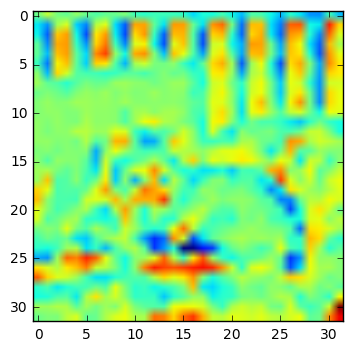

In [43]:
img = df_train.iloc[9,0:1024].values.reshape(32,32)
plt.imshow(img)

In [17]:
def length(x=0):

    import numpy as np
    l = np.max(np.shape(x))
    return l

################# 1D convolution	

def filter_1d(xin=0,h=0,boption=3):

    import numpy as np
    import scipy.linalg as lng
    import copy as cp    
    
    x = np.squeeze(cp.copy(xin));
    n = length(x);
    m = length(h);
    y = cp.copy(x);

    z = np.zeros(1,m);

    for r in range(np.int(np.floor(m/2))):
                
        if boption == 1: # --- zero padding
                        
            z = np.concatenate([np.zeros(m-r-np.floor(m/2)-1),x[0:r+np.floor(m/2)+1]],axis=0)
        
        if boption == 2: # --- periodicity
            
            z = np.concatenate([x[n-(m-(r+np.floor(m/2)))+1:n],x[0:r+np.floor(m/2)+1]],axis=0)
        
        if boption == 3: # --- mirror
            
            u = x[0:m-(r+np.floor(m/2))-1];
            u = u[::-1]
            z = np.concatenate([u,x[0:r+np.floor(m/2)+1]],axis=0)
                                     
        y[r] = np.sum(z*h)
        
        
    

    a = np.arange(np.int(np.floor(m/2)),np.int(n-m+np.floor(m/2)),1)

    for r in a:
        
        y[r] = np.sum(h*x[r-np.floor(m/2):m+r-np.floor(m/2)])
    

    a = np.arange(np.int(n-m+np.floor(m/2)+1),n,1)

    for r in a:
            
        if boption == 1: # --- zero padding
            
            z = np.concatenate([x[r-np.floor(m/2):n],np.zeros(m - (n-r) - np.floor(m/2))],axis=0)
        
        if boption == 2: # --- periodicity
            
            z = np.concatenate([x[r-np.floor(m/2):n],x[0:m - (n-r) - np.floor(m/2)]],axis=0)
        
        if boption == 3: # --- mirror
                        
            u = x[n - (m - (n-r) - np.floor(m/2) -1)-1:n]
            u = u[::-1]
            z = np.concatenate([x[r-np.floor(m/2):n],u],axis=0)
                    
        y[r] = np.sum(z*h)
    	
    return y


In [22]:
################# 1D convolution with the "a trous" algorithm	

def Apply_H1(x=0,h=0,scale=1,boption=3):

	import numpy as np
	import copy as cp
	
	m = length(h)
	
	if scale > 1:
		p = (m-1)*np.power(2,(scale-1)) + 1
		g = np.zeros( p)
		z = np.linspace(0,m-1,m)*np.power(2,(scale-1))
		g[z.astype(int)] = h
	
	else:
		g = h
				
	y = filter_1d(x,g,boption)
	
	return y
	

In [23]:
################# 2D "a trous" algorithm

def Starlet_Forward(x=0,h=[0.0625,0.25,0.375,0.25,0.0625],J=1,boption=3):

	import numpy as np
	import copy as cp
	
	nx = np.shape(x)
	c = np.zeros((nx[0],nx[1]))
	w = np.zeros((nx[0],nx[1],J))

	c = cp.copy(x)
	cnew = cp.copy(x)
	
	for scale in range(J):
		
		for r in range(nx[0]):
			
			cnew[r,:] = Apply_H1(c[r,:],h,scale,boption)
			
		for r in range(nx[1]):
		
			cnew[:,r] = Apply_H1(cnew[:,r],h,scale,boption)
			
		w[:,:,scale] = c - cnew;
		
		c = cp.copy(cnew);

	return c,w
	

In [28]:
    
	################# 2D "a trous" algorithm

def Starlet_Inverse(c=0,w=0):

	import numpy as np
	
	x = c+np.sum(w,axis=2)

	return x

In [37]:

boption=2
h = 1/16*np.array([1,4,6,4,1])
J = 3
c,w =Starlet_Forward(img,h,J,boption)

/Users/philippe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/philippe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/philippe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


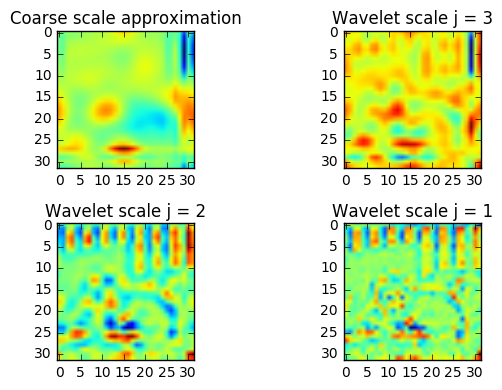

In [38]:
# Display the results
plt.figure(0)
plt.subplot(221)
plt.title('Coarse scale approximation')
plt.imshow(c)
plt.subplot(222)
plt.title('Wavelet scale j = 3')
plt.imshow(w[:,:,2])
plt.subplot(223)
plt.title('Wavelet scale j = 2')
plt.imshow(w[:,:,1])
plt.subplot(224)
plt.title('Wavelet scale j = 1')
plt.imshow(w[:,:,0])
plt.tight_layout()

# On garderait J=1

In [30]:
xrec =Starlet_Inverse(c,w)

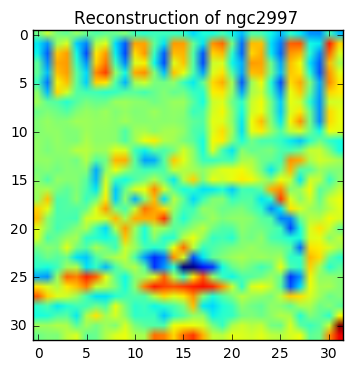

In [31]:
plt.imshow(xrec)
plt.title('Reconstruction of ngc2997 ')


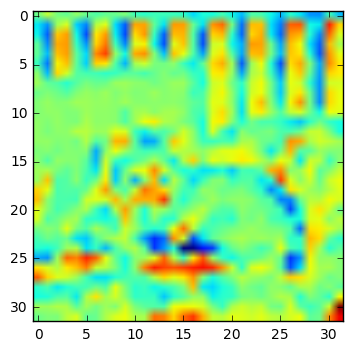

In [32]:
plt.imshow(img)

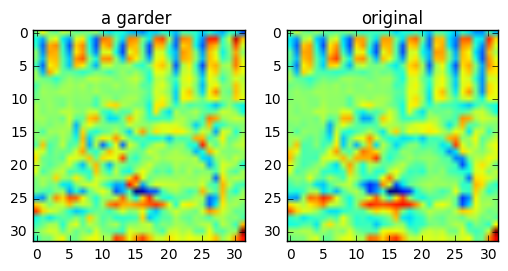

In [53]:
plt.subplot(121)
plt.imshow(w[:,:,0])
plt.title('a garder ')

plt.subplot(122)
plt.imshow(img)
plt.title('original')

In [ ]:
# TODO :
# faire une fonction
# faire passer toutes les images dans cette fonction